In [ ]:
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

     | 18.5MB 5.7MB/s
  Created wheel for Theano: filename=Theano-1.0.5+unknown-cp37-none-any.whl size=2667280 sha256=6cbac8a42c941504404063cc82c05f26f3ea86003b12d78474e9b311886e56de
  Stored in directory: /tmp/pip-ephem-wheel-cache-fk2212k9/wheels/33/73/96/0ed263c62a86e2485ea634e0d3ae8169d50fd66e3b252541db
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5
     | 604kB 10.6MB/s
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-cp37-none-any.whl size=122797 sha256=506efb75706be914fb323700a488225ad7d35c8712f0fa5e52a6140f3a755991
  Stored in directory: /tmp/pip-ephem-wheel-cache-973ayj2c/wheels/ca/4a/00/87f1777b229481fe76562df7c0cfb993bc88ed0cc37e3f0ed4
Successfully built Lasagne


In [ ]:
cd drive/My Drive/scripts

/content/drive/My Drive/scripts


In [ ]:
HOME_DIR = ''

# Path to SALICON raw data
pathToImages = ''
pathToMaps = ''
pathToFixationMaps = ''

# Path to processed data
pathOutputImages = ''
pathOutputMaps = ''
pathToPickle = ''

# Path to pickles which contains processed data
TRAIN_DATA_DIR = 'fix_trainData.pickle'
VAL_DATA_DIR = 'fix_validationData.pickle'
TEST_DATA_DIR = 'testData.pickle'

# Path to vgg16 pre-trained weights
PATH_TO_VGG16_WEIGHTS = 'vgg16.pkl'

# Input image and saliency map size
INPUT_SIZE = (256, 192)

# Directory to keep snapshots
DIR_TO_SAVE = 'test'

In [ ]:
import cv2
import numpy as np
from enum import Enum
import scipy.io


class InputType(Enum):
    image = 0
    imageGrayscale = 1
    saliencyMapMatlab = 2
    fixationMapMatlab = 3
    empty = 100


class LoadState(Enum):
    unloaded = 0
    loaded = 1
    loadedCompressed = 2
    error = 100


###############################################################################################

class ImageContainer:
    def __init__(self, filePath, imageType, state=LoadState.unloaded):

        self.filePath = filePath
        self.state = state
        self.imageType = imageType

        if self.state == LoadState.unloaded:
            self.data = None
        elif self.state == LoadState.loaded:
            self.load()
        elif self.state == LoadState.loadedCompressed:
            self.loadCompressed()
        else:
            raise Exception('Unknown state when loading image')

    def load(self):

        if self.imageType == InputType.image:
            self.data = cv2.cvtColor(cv2.imread(self.filePath, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
            self.state = LoadState.loaded
        if self.imageType == InputType.imageGrayscale:
            self.data = cv2.cvtColor(cv2.imread(self.filePath, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
            self.state = LoadState.loaded
        elif self.imageType == InputType.saliencyMapMatlab:
            self.data = (scipy.io.loadmat(self.filePath)['I'] * 255).astype(np.uint8)
            self.state = LoadState.loaded
        elif self.imageType == InputType.fixationMapMatlab:
            self.data = (scipy.io.loadmat(self.filePath)['I']).nonzero()
            self.state = LoadState.loaded
        elif self.imageType == InputType.empty:
            self.data = None

    def loadCompressed(self):

        if self.imageType == InputType.image:
            with open(self.filePath, 'rb') as f:
                data = f.read()
            self.data = np.fromstring(data, np.uint8)
            self.state = LoadState.loadedCompressed
        elif self.imageType == InputType.saliencyMapMatlab:
            self.state = LoadState.error
            raise Exception('Saliency maps do no have compressed handlind method enabled')
        elif self.imageType == InputType.empty:
            self.state = LoadState.error
            raise Exception('Empty images do no have compressed handlind method enabled')

    def getImage(self):

        if self.imageType == InputType.image:
            if self.state == LoadState.unloaded:
                return cv2.cvtColor(cv2.imread(self.filePath, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
            elif self.state == LoadState.loaded:
                return self.data
            elif self.state == LoadState.loadedCompressed:
                return cv2.cvtColor(cv2.imdecode(self.data, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        elif self.imageType == InputType.imageGrayscale:
            if self.state == LoadState.unloaded:
                return cv2.cvtColor(cv2.imread(self.filePath, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
            elif self.state == LoadState.loaded:
                return self.data
            elif self.state == LoadState.loadedCompressed:
                return cv2.cvtColor(cv2.imdecode(self.data, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
        elif self.imageType == InputType.saliencyMapMatlab:
            if self.state == LoadState.unloaded:
                return (scipy.io.loadmat(self.filePath)['I'] * 255).astype(np.uint8)
            elif self.state == LoadState.loaded:
                return self.data
            elif self.state == LoadState.loadedCompressed:
                raise Exception('Saliency maps do no have compressed handlind method enabled')
                return None
        elif self.imageType == InputType.fixationMapMatlab:
            if self.state == LoadState.unloaded:
                return (scipy.io.loadmat(self.filePath)['I']).astype(np.uint8)
            elif self.state == LoadState.loaded:
                return self.data
            elif self.state == LoadState.loadedCompressed:
                raise Exception('Fixation maps do no have compressed handlind method enabled')
                return None
        elif self.imageType == InputType.empty:
            return None


###############################################################################################

# class Target():
#     def __init__(self, imagePath, saliencyPath,
#                  imageState=LoadState.unloaded, imageType=InputType.image,
#                  saliencyState=LoadState.unloaded, saliencyType=InputType.saliencyMapMatlab):
#         self.image = ImageContainer(imagePath, imageType, imageState)
#         self.saliency = ImageContainer(saliencyPath, saliencyType, saliencyState)

class Target():
    def __init__(self, imagePath, saliencyPath,fixationPath,
                 imageState=LoadState.unloaded, imageType=InputType.image,
                 saliencyState=LoadState.unloaded, saliencyType=InputType.saliencyMapMatlab,
                 fixationState=LoadState.unloaded, fixationType=InputType.fixationMapMatlab):
        self.image = ImageContainer(imagePath, imageType, imageState)
        self.saliency = ImageContainer(saliencyPath, saliencyType, saliencyState)
        self.fixation = ImageContainer(fixationPath, fixationType, fixationState)

In [ ]:
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Upscale2DLayer
from lasagne.nonlinearities import sigmoid
import lasagne
import pickle


def set_pretrained_weights(net, path_to_model_weights=PATH_TO_VGG16_WEIGHTS):
    # Set out weights
    vgg16 = pickle.load(open(path_to_model_weights,'rb'),encoding='latin-1')
    #with open(path_to_model_weights, 'rb') as f:
    #  vgg16 = pickle.load(f, encoding='latin-1')
    num_elements_to_set = 26  # Number of W and b elements for the first convolutional layers
    lasagne.layers.set_all_param_values(net['conv5_3'], vgg16['param values'][:num_elements_to_set])


def build_encoder(input_height, input_width, input_var):
    encoder = build(input_height, input_width, input_var)
    set_pretrained_weights(encoder)
    return encoder


def build_decoder(net):
    net['uconv5_3']= ConvLayer(net['conv5_3'], 512, 3, pad=1)
    print ("uconv5_3: {}".format(net['uconv5_3'].output_shape[1:]))

    net['uconv5_2'] = ConvLayer(net['uconv5_3'], 512, 3, pad=1)
    print ("uconv5_2: {}".format(net['uconv5_2'].output_shape[1:]))

    net['uconv5_1'] = ConvLayer(net['uconv5_2'], 512, 3, pad=1)
    print ("uconv5_1: {}".format(net['uconv5_1'].output_shape[1:]))

    net['upool4'] = Upscale2DLayer(net['uconv5_1'], scale_factor=2)

    net['uconv4_3'] = ConvLayer(net['upool4'], 512, 3, pad=1)

    net['uconv4_2'] = ConvLayer(net['uconv4_3'], 512, 3, pad=1)

    net['uconv4_1'] = ConvLayer(net['uconv4_2'], 512, 3, pad=1)

    net['upool3'] = Upscale2DLayer(net['uconv4_1'], scale_factor=2)

    net['uconv3_3'] = ConvLayer(net['upool3'], 256, 3, pad=1)

    net['uconv3_2'] = ConvLayer(net['uconv3_3'], 256, 3, pad=1)

    net['uconv3_1'] = ConvLayer(net['uconv3_2'], 256, 3, pad=1)

    net['upool2'] = Upscale2DLayer(net['uconv3_1'], scale_factor=2)

    net['uconv2_2'] = ConvLayer(net['upool2'], 128, 3, pad=1)

    net['uconv2_1'] = ConvLayer(net['uconv2_2'], 128, 3, pad=1)

    net['upool1'] = Upscale2DLayer(net['uconv2_1'], scale_factor=2)

    net['uconv1_2'] = ConvLayer(net['upool1'], 64, 3, pad=1,)

    net['uconv1_1'] = ConvLayer(net['uconv1_2'], 64, 3, pad=1)

    net['output'] = ConvLayer(net['uconv1_1'], 1, 1, pad=0,nonlinearity=sigmoid)

    return net


def build1(input_height, input_width, input_var):
    encoder = build_encoder(input_height, input_width, input_var)
    generator = build_decoder(encoder)
    return generator

In [ ]:
import theano.tensor as T


class Model(object):
    def __init__(self, input_width, input_height, batch_size=32):
        
        self.inputWidth = input_width
        self.inputHeight = input_height

        self.G_lr = None
        self.D_lr = None
        self.momentum = None

        self.net = None
        self.discriminator = None
        self.batch_size = batch_size

        self.D_trainFunction = None
        self.G_trainFunction = None
        self.predictFunction = None
        self.input_var = T.tensor4()
        self.output_var = T.tensor4()

In [ ]:
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import InputLayer



def build(inputHeight, inputWidth, input_var):
    """
    Bulid only Convolutional part of the VGG-16 Layer model, all fully connected layers are removed.
    First 3 group of ConvLayers are fixed (not trainable).

    :param input_layer: Input layer of the network.
    :return: Dictionary that contains all layers.
    """

    net = {'input': InputLayer((None, 3, inputHeight, inputWidth), input_var=input_var)}
    
    net['bgr'] = RGBtoBGRLayer(net['input'])

    net['conv1_1'] = ConvLayer(net['bgr'], 64, 3, pad=1, flip_filters=False)
    net['conv1_1'].add_param(net['conv1_1'].W, net['conv1_1'].W.get_value().shape, trainable=False)
    net['conv1_1'].add_param(net['conv1_1'].b, net['conv1_1'].b.get_value().shape, trainable=False)
    
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'].add_param(net['conv1_2'].W, net['conv1_2'].W.get_value().shape, trainable=False)
    net['conv1_2'].add_param(net['conv1_2'].b, net['conv1_2'].b.get_value().shape, trainable=False)
    
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_1'].add_param(net['conv2_1'].W, net['conv2_1'].W.get_value().shape, trainable=False)
    net['conv2_1'].add_param(net['conv2_1'].b, net['conv2_1'].b.get_value().shape, trainable=False)
    
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'].add_param(net['conv2_2'].W, net['conv2_2'].W.get_value().shape, trainable=False)
    net['conv2_2'].add_param(net['conv2_2'].b, net['conv2_2'].b.get_value().shape, trainable=False)
    
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_1'].add_param(net['conv3_1'].W, net['conv3_1'].W.get_value().shape, trainable=False)
    net['conv3_1'].add_param(net['conv3_1'].b, net['conv3_1'].b.get_value().shape, trainable=False)
    
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'].add_param(net['conv3_2'].W, net['conv3_2'].W.get_value().shape, trainable=False)
    net['conv3_2'].add_param(net['conv3_2'].b, net['conv3_2'].b.get_value().shape, trainable=False)
    
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'].add_param(net['conv3_3'].W, net['conv3_3'].W.get_value().shape, trainable=False)
    net['conv3_3'].add_param(net['conv3_3'].b, net['conv3_3'].b.get_value().shape, trainable=False)
    
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_1'].add_param(net['conv4_1'].W, net['conv4_1'].W.get_value().shape)
    net['conv4_1'].add_param(net['conv4_1'].b, net['conv4_1'].b.get_value().shape)
    
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'].add_param(net['conv4_2'].W, net['conv4_2'].W.get_value().shape)
    net['conv4_2'].add_param(net['conv4_2'].b, net['conv4_2'].b.get_value().shape)
    
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'].add_param(net['conv4_3'].W, net['conv4_3'].W.get_value().shape)
    net['conv4_3'].add_param(net['conv4_3'].b, net['conv4_3'].b.get_value().shape)
    
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_1'].add_param(net['conv5_1'].W, net['conv5_1'].W.get_value().shape)
    net['conv5_1'].add_param(net['conv5_1'].b, net['conv5_1'].b.get_value().shape)
    
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'].add_param(net['conv5_2'].W, net['conv5_2'].W.get_value().shape)
    net['conv5_2'].add_param(net['conv5_2'].b, net['conv5_2'].b.get_value().shape)
    
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'].add_param(net['conv5_3'].W, net['conv5_3'].W.get_value().shape)
    net['conv5_3'].add_param(net['conv5_3'].b, net['conv5_3'].b.get_value().shape)
    
    return net

In [ ]:
import lasagne
import numpy as np
import theano


class RGBtoBGRLayer(lasagne.layers.Layer):
    def __init__(self, l_in, bgr_mean=np.array([103.939, 116.779, 123.68]),
                 data_format='bc01', **kwargs):
        """A Layer to normalize and convert images from RGB to BGR
        This layer converts images from RGB to BGR to adapt to Caffe
        that uses OpenCV, which uses BGR. It also subtracts the
        per-pixel mean.
        Parameters
        ----------
        l_in : :class:``lasagne.layers.Layer``
            The incoming layer, typically an
            :class:``lasagne.layers.InputLayer``
        bgr_mean : iterable of 3 ints
            The mean of each channel. By default, the ImageNet
            mean values are used.
        data_format : str
            The format of l_in, either `b01c` (batch, rows, cols,
            channels) or `bc01` (batch, channels, rows, cols)
        """
        super(RGBtoBGRLayer, self).__init__(l_in, **kwargs)
        assert data_format in ['bc01', 'b01c']
        self.l_in = l_in
        floatX = theano.config.floatX
        self.bgr_mean = bgr_mean.astype(floatX)
        self.data_format = data_format

    def get_output_for(self, input_im, **kwargs):
        if self.data_format == 'bc01':
            input_im = input_im[:, ::-1, :, :]
            input_im -= self.bgr_mean[:, np.newaxis, np.newaxis]
        else:
            input_im = input_im[:, :, :, ::-1]
            input_im -= self.bgr_mean
        return input_im

In [ ]:
import lasagne
from lasagne.layers import InputLayer
import theano
import theano.tensor as T
import numpy as np



class ModelBCE(Model):
    def __init__(self, w, h, batch_size=32, lr=0.001):
        super(ModelBCE, self).__init__(w, h, batch_size)

        self.net = build1(self.inputHeight, self.inputWidth, self.input_var)

        output_layer_name = 'output'
        prediction = lasagne.layers.get_output(self.net[output_layer_name])

        test_prediction = lasagne.layers.get_output(self.net[output_layer_name], deterministic=True)
        self.predictFunction = theano.function([self.input_var], test_prediction)

        output_var_pooled = T.signal.pool.pool_2d(self.output_var, (4, 4), mode="average_exc_pad", ignore_border=True)
        prediction_pooled = T.signal.pool.pool_2d(prediction, (4, 4), mode="average_exc_pad", ignore_border=True)

        bce = lasagne.objectives.binary_crossentropy(prediction_pooled, output_var_pooled).mean()
        train_err = bce

        # parameters update and training
        G_params = lasagne.layers.get_all_params(self.net[output_layer_name], trainable=True)
        self.G_lr = theano.shared(np.array(lr, dtype=theano.config.floatX))
        G_updates = lasagne.updates.nesterov_momentum(train_err, G_params, learning_rate=self.G_lr, momentum=0.5)

        self.G_trainFunction = theano.function(inputs=[self.input_var, self.output_var], outputs=train_err, updates=G_updates,
                                               allow_input_downcast=True)


In [ ]:
import os
import numpy as np
import cv2
import theano
import lasagne


def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i + n]


def load_weights(net, path, epochtoload):
    """
    Load a pretrained model
    :param epochtoload: epoch to load
    :param net: model object
    :param path: path of the weights to be set
    """
    with np.load(HOME_DIR + path + "modelWeights{:04d}.npz".format(epochtoload)) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(net, param_values)


def predict1(model, image_stimuli, num_epoch=None, name=None, path_output_maps=None):

    size = (image_stimuli.shape[1], image_stimuli.shape[0])
    blur_size = 5

    if image_stimuli.shape[:2] != (model.inputHeight, model.inputWidth):
        image_stimuli = cv2.resize(image_stimuli, (model.inputWidth, model.inputHeight), interpolation=cv2.INTER_AREA)

    blob = np.zeros((1, 3, model.inputHeight, model.inputWidth), theano.config.floatX)

    blob[0, ...] = (image_stimuli.astype(theano.config.floatX).transpose(2, 0, 1))

    result = np.squeeze(model.predictFunction(blob))
    saliency_map = (result * 255).astype(np.uint8)

    # resize back to original size
    saliency_map = cv2.resize(saliency_map, size, interpolation=cv2.INTER_CUBIC)
    # blur
    saliency_map = cv2.GaussianBlur(saliency_map, (blur_size, blur_size), 0)
    # clip again
    saliency_map = np.clip(saliency_map, 0, 255)
    if name is None:
        # When we use for testing, there is no file name provided.
        cv2.imwrite('./' + path_output_maps + '/validationRandomSaliencyPred_{:04d}.png'.format(num_epoch), saliency_map)
    else:
        cv2.imwrite(os.path.join(path_output_maps, name + '.jpg'), saliency_map)


In [ ]:
      
import os
import numpy as np
from tqdm import tqdm
import cv2
import glob



def test(path_to_images, path_output_maps, model_to_test=None):
  list_img_files = [k.split('/')[-1].split('.')[0] for k in glob.glob(os.path.join(path_to_images, '*'))]
  list_img_files = ["1.jpg"]
  list_img_files.sort()
  for curr_file in tqdm(list_img_files, ncols=20):
    img = cv2.cvtColor(cv2.imread(("IMG_20210309_183233.jpg"), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    predict(model=model_to_test, image_stimuli=img, name=curr_file, path_output_maps=path_output_maps)


def main():
    # Create network
    model = ModelBCE(INPUT_SIZE[0], INPUT_SIZE[1], batch_size=8)
    # Here need to specify the epoch of model sanpshot
    load_weights(model.net['output'], path='gen_', epochtoload=90)
    # Here need to specify the path to images and output path
    test(path_to_images='', path_output_maps='', model_to_test=model)

if __name__ == "__main__":
    main()

uconv5_3: (512, 12, 16)
uconv5_2: (512, 12, 16)
uconv5_1: (512, 12, 16)


100%|█| 1/1 [00:04<0


In [ ]:
def predict(model, image_stimuli, num_epoch=None, name=None, path_output_maps=None):

    size = (image_stimuli.shape[1], image_stimuli.shape[0])
    blur_size = 5

    if image_stimuli.shape[:2] != (model.inputHeight, model.inputWidth):
        image_stimuli = cv2.resize(image_stimuli, (model.inputWidth, model.inputHeight), interpolation=cv2.INTER_AREA)

    blob = np.zeros((1, 3, model.inputHeight, model.inputWidth), theano.config.floatX)

    blob[0, ...] = (image_stimuli.astype(theano.config.floatX).transpose(2, 0, 1))

    result = np.squeeze(model.predictFunction(blob))
    saliency_map = (result * 255).astype(np.uint8)

    # resize back to original size
    saliency_map = cv2.resize(saliency_map, size, interpolation=cv2.INTER_CUBIC)
    # blur
    saliency_map = cv2.GaussianBlur(saliency_map, (blur_size, blur_size), 0)
    # clip again
    saliency_map = np.clip(saliency_map, 0, 255)
    return saliency_map

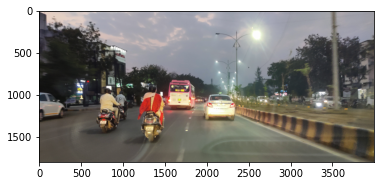

In [ ]:
from PIL import Image 
from matplotlib import pyplot as plt
from torch import nn
import torchvision
import os
import torch
import torch.utils.data as data
import torchvision.transforms as transforms

image_pil = Image.open("IMG_20210309_183233.jpg")
image = np.array(image_pil)
plt.imshow(image)
plt.show()


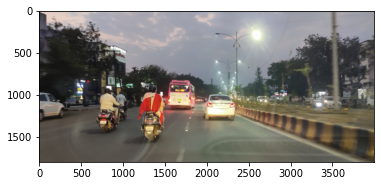

In [ ]:
img = cv2.cvtColor(cv2.imread(("IMG_20210309_183233.jpg"), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
model = ModelBCE(INPUT_SIZE[0], INPUT_SIZE[1], batch_size=8)
load_weights(model.net['output'], path='gen_', epochtoload=90)
    


uconv5_3: (512, 12, 16)
uconv5_2: (512, 12, 16)
uconv5_1: (512, 12, 16)


In [ ]:
def predict1(model, image_stimuli, num_epoch=None, name=None, path_output_maps=None):

    size = (image_stimuli.shape[1], image_stimuli.shape[0])
    blur_size = 5

    if image_stimuli.shape[:2] != (model.inputHeight, model.inputWidth):
        image_stimuli = cv2.resize(image_stimuli, (model.inputWidth, model.inputHeight), interpolation=cv2.INTER_AREA)

    blob = np.zeros((1, 3, model.inputHeight, model.inputWidth), theano.config.floatX)

    blob[0, ...] = (image_stimuli.astype(theano.config.floatX).transpose(2, 0, 1))

    result = np.squeeze(model.predictFunction(blob))
    saliency_map = (result * 255).astype(np.uint8)

    # resize back to original size
    saliency_map = cv2.resize(saliency_map, size, interpolation=cv2.INTER_CUBIC)
    # blur
    saliency_map = cv2.GaussianBlur(saliency_map, (blur_size, blur_size), 0)
    # clip again
    saliency_map = np.clip(saliency_map, 0, 255)
    return saliency_map

In [ ]:
i1 = predict1(model=model, image_stimuli=img, name=None, path_output_maps=None)

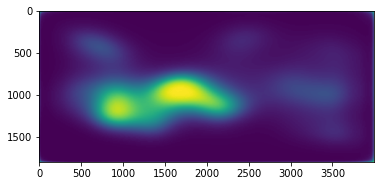

In [ ]:

plt.imshow(i1)
plt.show()

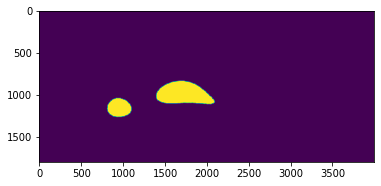

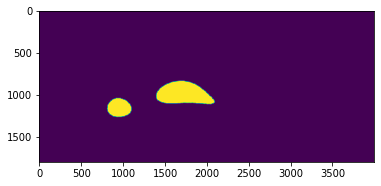

In [ ]:
threshhold = 0.4
threshhold *= 255 

binarized_saliencymap = i1>threshhold # ndarray, (h, w), bool

plt.imshow(binarized_saliencymap)
plt.show()
import matplotlib.patches as patches


binarized_saliencymap = binarized_saliencymap.astype(np.uint8)
box_x, box_y, box_width, box_height = cv2.boundingRect(binarized_saliencymap)
fig = plt.figure()
ax = plt.axes()
ax.imshow(binarized_saliencymap)
plt.show()

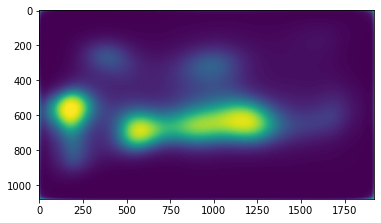

In [ ]:
import matplotlib.patches as patches

def color_saliencymap(saliencymap):
    assert saliencymap.dtype==np.uint8
    assert (saliencymap.ndim == 2) or (saliencymap.ndim == 3)

    saliencymap_colored = cv2.applyColorMap(saliencymap, cv2.COLORMAP_JET)[:, :, ::-1]

    return saliencymap_colored

def overlay_saliencymap_and_image(saliencymap_color, image):
    assert saliencymap_color.ndim==3
    assert saliencymap_color.dtype==np.uint8
    assert image.ndim==3
    assert image.dtype==np.uint8
    im_size = (image.shape[1], image.shape[0])
    saliencymap_color = cv2.resize(saliencymap_color, im_size, interpolation=cv2.INTER_CUBIC)
    overlaid_image = cv2.addWeighted(src1=image, alpha=1, src2=saliencymap_color, beta=0.7, gamma=0)
    return overlaid_image

saliencymap_colored = color_saliencymap(i1) # ndarray, (h, w, rgb), np.uint8
overlaid_image = overlay_saliencymap_and_image(saliencymap_colored, image) # ndarray, (h, w, rgb), np.uint8
fig = plt.figure()
ax = plt.axes()
ax.imshow(i1)
plt.show()


1920
1080


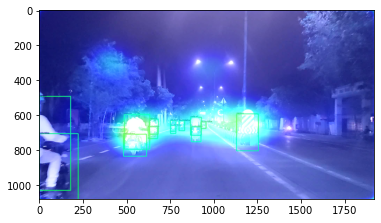

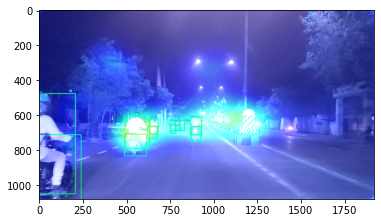

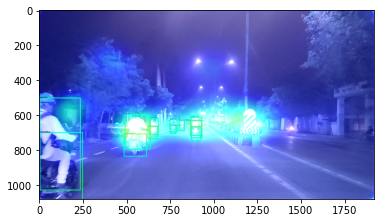

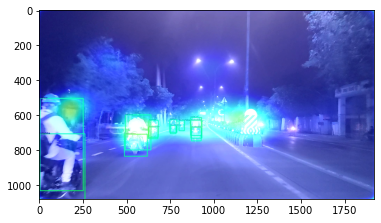

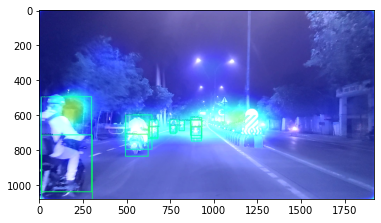

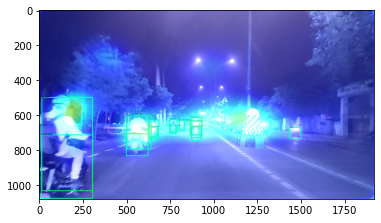

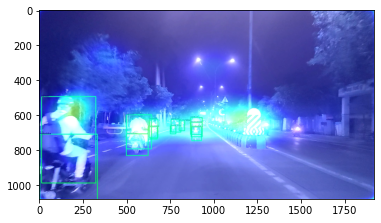

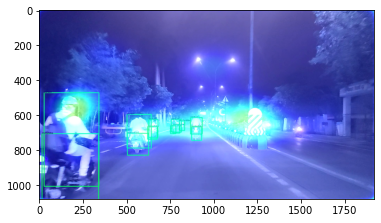

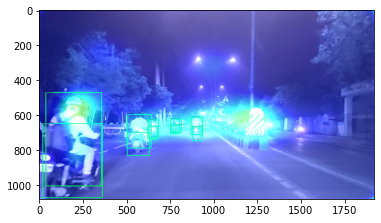

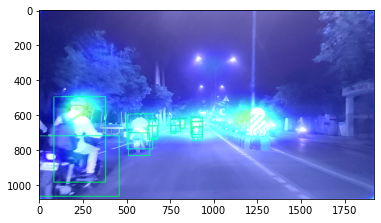

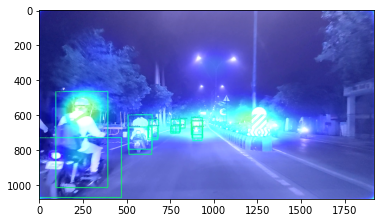

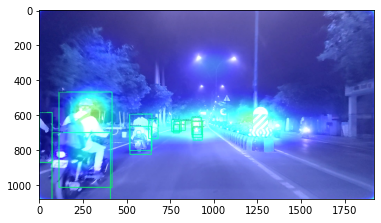

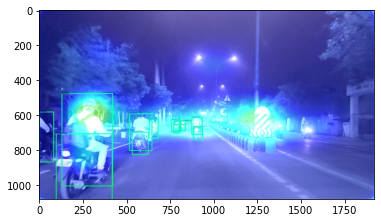

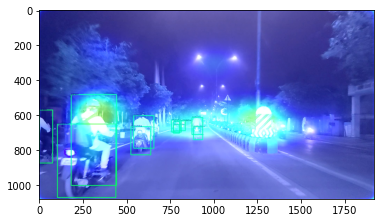

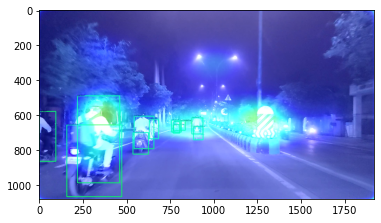

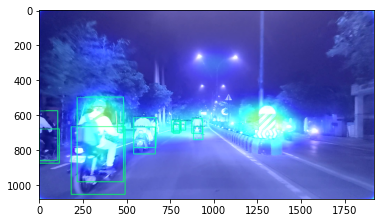

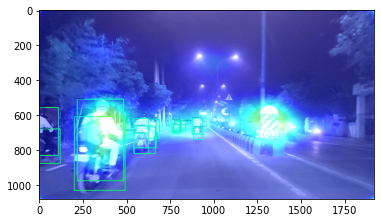

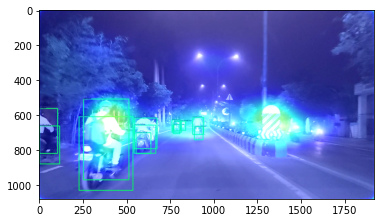

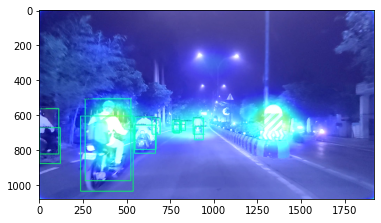

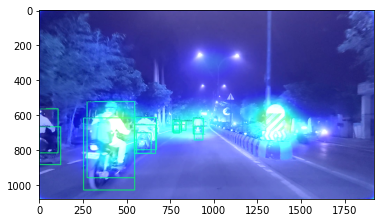

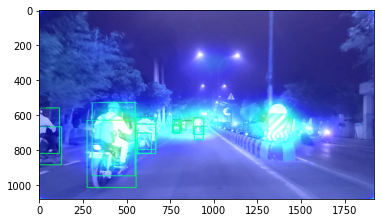

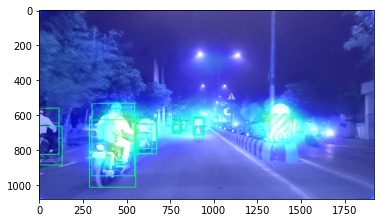

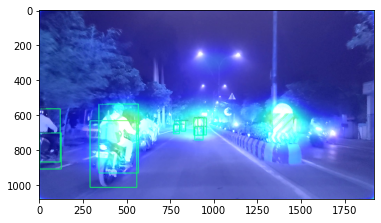

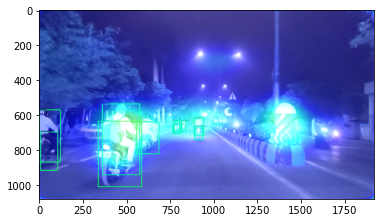

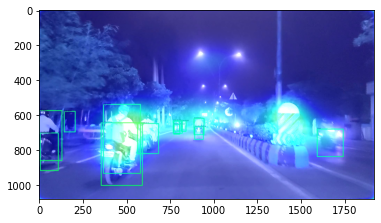

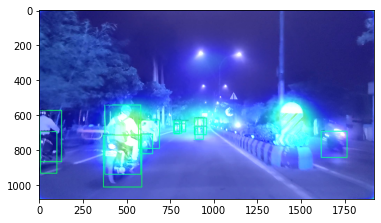

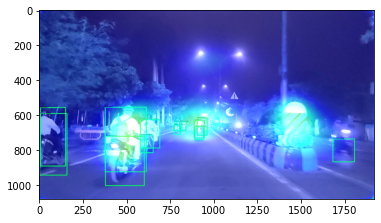

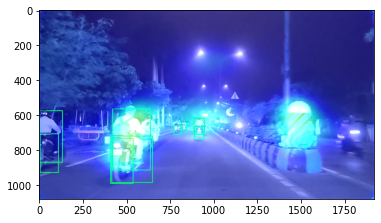

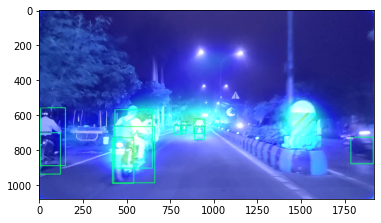

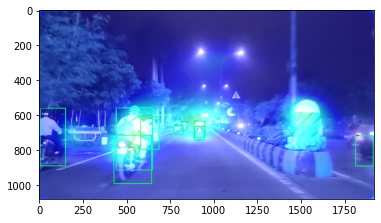

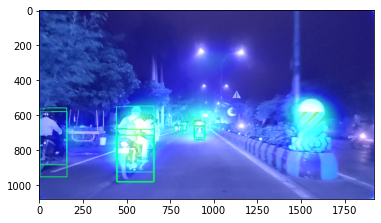

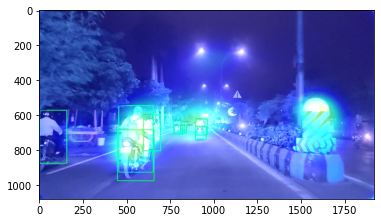

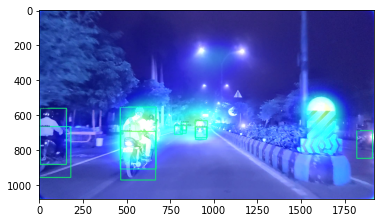

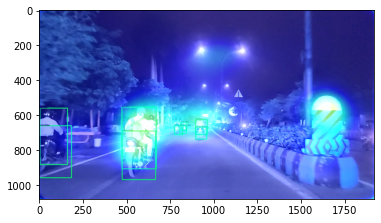

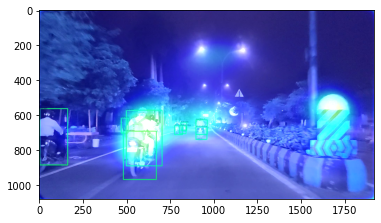

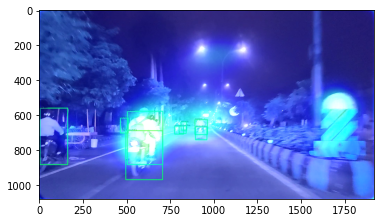

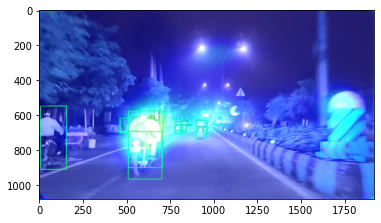

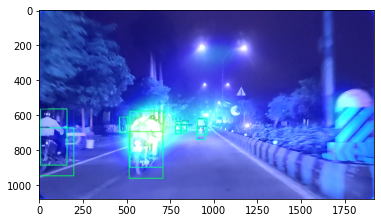

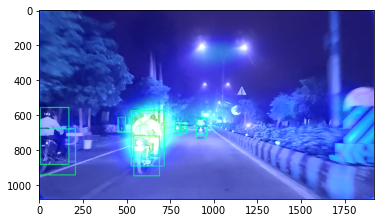

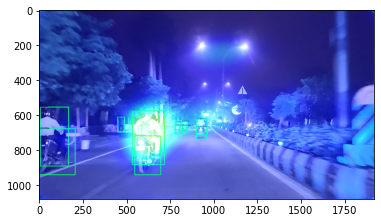

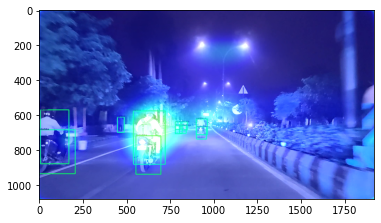

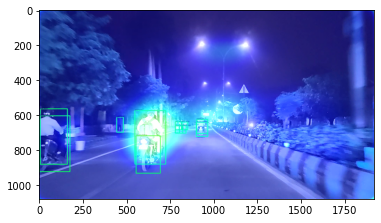

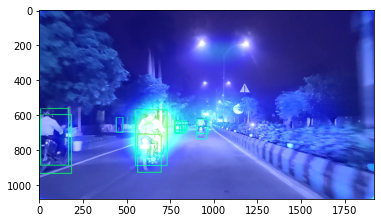

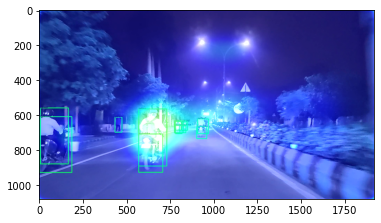

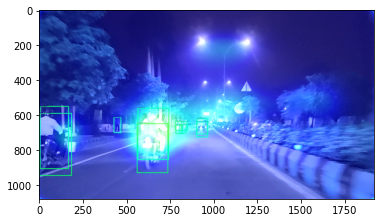

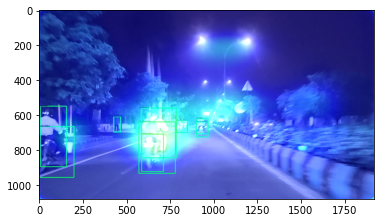

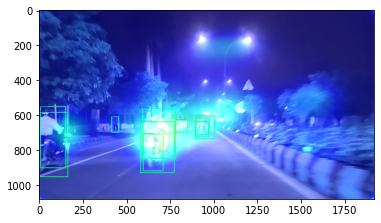

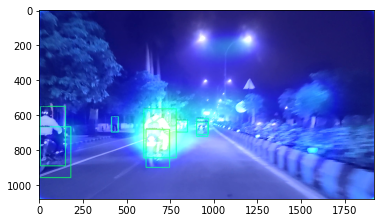

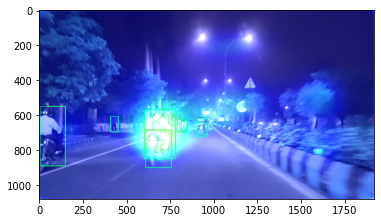

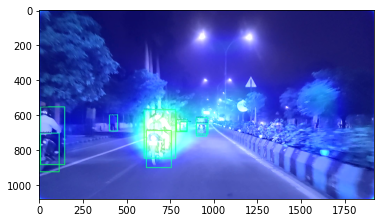

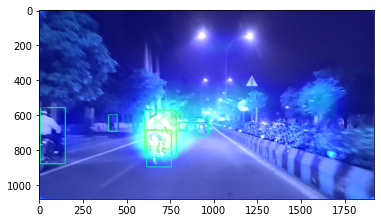

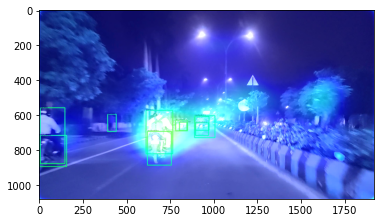

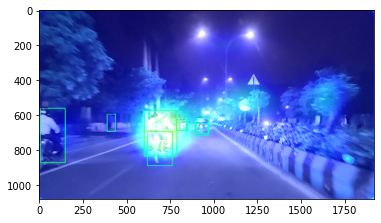

KeyboardInterrupt: ignored

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('videet_final_final.mp4')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
saliency = None
print(frame_width)
print(frame_height)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc , 20.0, (1280,360))
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
count = 0

while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  i1 = predict1(model=model, image_stimuli=frame, name=None, path_output_maps=None)
  saliencymap_colored = color_saliencymap(i1) # ndarray, (h, w, rgb), np.uint8
  overlaid_image = overlay_saliencymap_and_image(saliencymap_colored, frame) # ndarray, (h, w, rgb), np.uint8
  fig = plt.figure()
  ax = plt.axes()
  ax.imshow(overlaid_image)
  plt.show()
  ax.imshow(overlaid_image)
  plt.show()
  '''g2 = cv2.cvtColor(threshMap,cv2.COLOR_GRAY2RGB)
    r = g2[:, :,0]
    gr = g2[:, :,1]#-g2[:, :,1]
    b = g2[:, :,2]-g2[:, :,2]
    a =[]
    a.append(r)
    a.append(gr)
    a.append(b)
    a = np.array(a)
    a = np.rollaxis(a,0,3)
    a.shape
    # plt.imshow(a)
    # out.write(saliencyMap)
    # print(a.shape)
    # dst = cv2.addWeighted(frame, 0.5, a, 0.5, 10)
    dst = cv2.addWeighted(frame, 0.3, a, 1, 30)
    vis = np.concatenate((frame, dst), axis=1)
    # plt.imshow(vis)
    # print(vis.shape)
    out.write(vis)
    '''

